# Building MNIST-1D
Sam Greydanus | 2020

This notebook shows how to build the MNIST-1D dataset in full detail*.

_* If you're running this in Colab, it's best to use a GPU runtime._

In [1]:
# Uncomment and Run this if you're in a Colab
# !git clone https://github.com/greydanus/mnist1d

In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

PROJECT_DIR = './'

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cpu


## Templates
These are 1D signals, consisting of 12 points each, that resemble the digits 0-9. They are meant to be analogous to the handwritten digits 0-9 in the original MNIST dataset:

![mnist digits](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/mnist2d_black.png)

But unlike the original MNIST dataset, which consisted of 2D arrays of pixels (each image had 28x28=784 dimensions), this dataset consists of 1D timeseries of length 40. This means each example is ~20x smaller, making the dataset much quicker and easier to iterate over.

In [3]:
def get_templates():
    """Create a set of 10 templates for the digits 0-9. Each template is a 1D signal with 12 points."""
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    # stack the templates into a 2D array where each row is a template
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])

    # normalize the templates to zero mean and unit variance
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)

    # subtract the first element (which is the same as the last element) so that the signal starts and ends at 0
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6.,     # divide by 6 to make the max value 1
                 't': np.linspace(-5, 5, len(d0))/6.,   # time axis scaled to be within [-1,1]
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}    # labels which are digits
    return templates

def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
print("Examples from original MNIST dataset:")
URL = 'https://raw.githubusercontent.com/greydanus/mnist1d/master/static/mnist.png'
Image(url= URL,  width=800)

Examples from original MNIST dataset:


Templates for the MNIST-1D dataset:


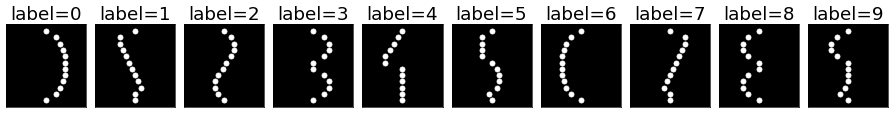

In [5]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=True)

# fig.savefig(PROJECT_DIR + 'static/mnist1d_black.png')

Templates for the MNIST-1D dataset:


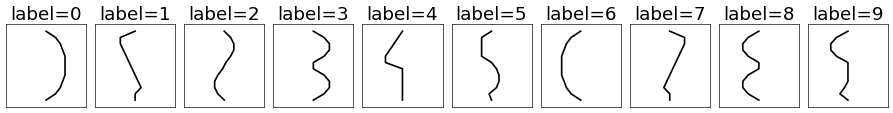

In [6]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=False)

# fig.savefig(PROJECT_DIR + 'static/mnist1d_white.png')

## Transformations
In order to build a synthetic dataset, we are going to pass the templates through a series of random transformations. This includes adding random amounts of padding, translation, correlated noise, iid noise, and scaling.

We use these transformations because they are relevant for both 1D and 2D images. So even though our dataset is 1D, we can expect some of our findings to hold for 2D (image) data. For example, we can study the advantage of using a translation-invariant model by making a dataset where signals occur at different locations in the sequence. We can do this by using large padding and translation coefficients.

In the following section, we plot the step-by-step transformations of digit templates into dataset examples. Note that you can generate your own synthetic datasets by changing the relevant hyperparameters.

In [7]:
# transformations of the templates which will make them harder to fit
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)

## Visualize Transformations
We'll apply one at a time so it's clear what each transformation is doing.

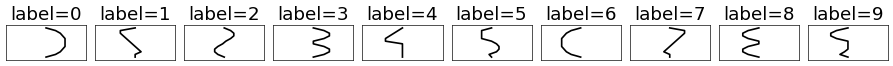

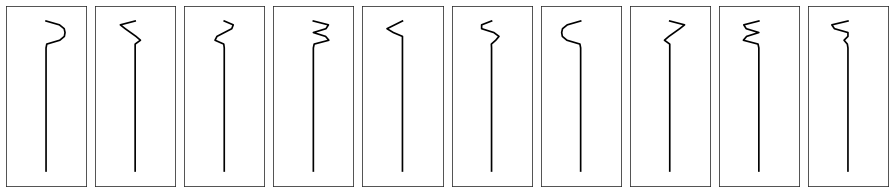

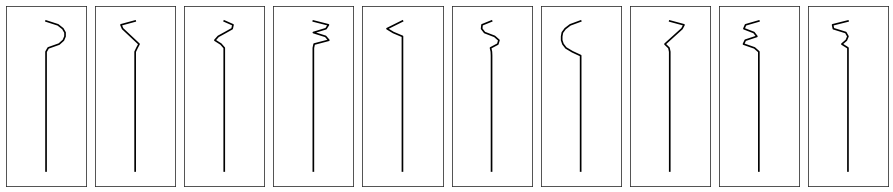

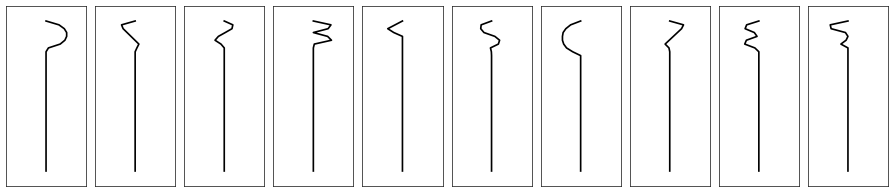

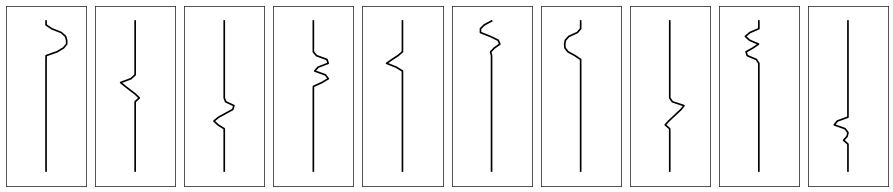

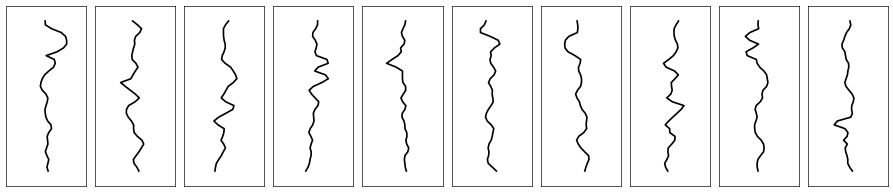

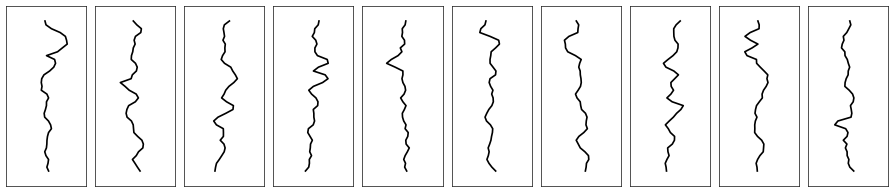

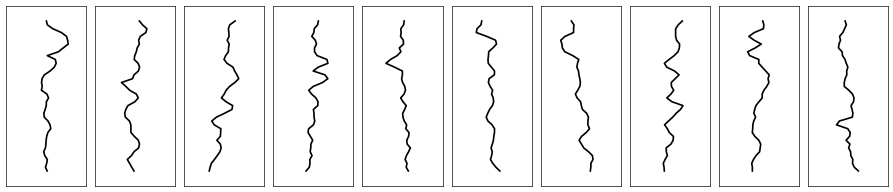

In [8]:
def apply_ablations(arg_dict, n=7):
    ablations = [('shear_scale', 0),
                ('iid_noise_scale', 0),
                ('corr_noise_scale', 0),
                 ('max_translation', 1),
                 ('scale_coeff', 0),
                 ('padding', [arg_dict['padding'][-1], arg_dict['padding'][-1]]),
                 ('padding', [0, 0]),]
    num_ablations = min(n, len(ablations))
    for i in range(num_ablations):
        k, v = ablations[i]
        arg_dict[k] = v
    return arg_dict

templates = get_templates()
for i, n in enumerate(reversed(range(8))):
    np.random.seed(0)
    arg_dict = get_dataset_args(as_dict=True)
    arg_dict = apply_ablations(arg_dict, n=n)
    args = ObjectView(arg_dict)
    do_transform = args.padding[0] != 0
    fig = plot_signals(templates['x'], templates['t'], labels=None if do_transform else templates['y'],
                 args=args, ratio=2.2 if do_transform else 0.8,
                 do_transform=do_transform)
#     fig.savefig(PROJECT_DIR + 'static/transform_{}.png'.format(i))

## Construct a  dataset
Now we can construct a dataset by applying random transformations to the template signals.

In [9]:
def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [10]:
args = get_dataset_args()
set_seed(args.seed)
args.shuffle_seq = False
data = make_dataset(args=args)  # make the dataset

set_seed(args.seed)
args.shuffle_seq = True
data_shuff = make_dataset(args=args)  # make the dataset, shuffling the spatial dimension

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40
Number of classes: 10


## You can also download the original dataset from the GitHub repo
This is the best thing to do if you want to compare your MNIST1D results to someone else's results, since that .pkl file will never change (whereas, if we are unlucky, the libraries used to synthesize the dataset may change slightly).

In [11]:
import sys ; sys.path.append('..')  # useful if you're running locally
import mnist1d

args = mnist1d.get_dataset_args()
data = mnist1d.get_dataset(args, path='./mnist1d_data.pkl', download=True) # This is the default setting

File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl


In [25]:
type(data)
data.keys()
data['x'].shape

(4000, 40)

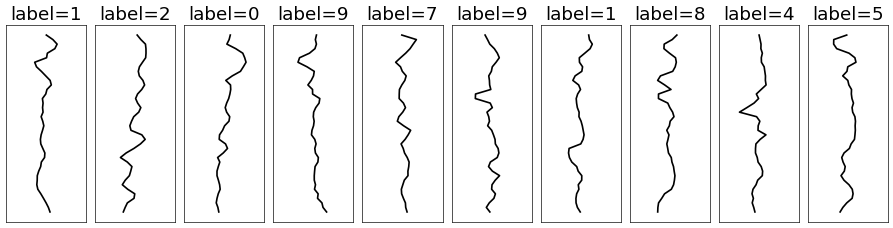

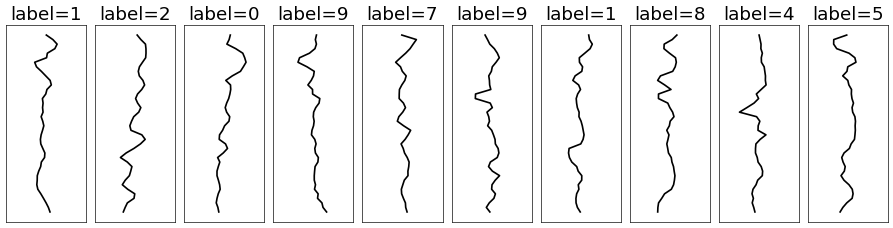

In [36]:
import numpy as np

# Assuming data is a dictionary with a key 'x' that maps to a 2D array
# and plot_signals is a function that takes a 2D array as input

# Generate 10 random indices
indices = np.random.choice(data['x'].shape[0], size=10, replace=False)

# Select the samples at these indices
samples = data['x'][indices]

# Plot the samples
plot_signals(samples, data['t'], labels=data['y'][indices], args=args, ratio=2.6, do_transform=False, dark_mode=False, zoom=6)

## Get a strong human baseline
This takes time and care. But it's weirdly addicting, especially when you realize that you might end up losing to a ConvNet. I tested myself on five "quizzes" of a hundred examples each.

### Quiz: step 1
Run the following cell to set up the quiz. It will initialize the relevant variables and set ``ix`` to the test set example from which you will start.

In [12]:
from mnist1d.utils import from_pickle, to_pickle  # we'll need these utilities to load/save results

# ix = 0
ix = 0
ix = ix - 10 # the first thing we're going to do is add 10
datas, guesses, trues = [], [], []
quiz_tag = 'q1' # name of the quiz. Set this manually

### Quiz: steps 2 & 3
Run the next cell to plot 10 test set examples. Enter your guess in the next cell and run it to compare your response to the ground truth.

Once you have understood your mistakes, run the first cell again in order to plot the next 10 examples. Repeat this process until ``len(guesses)=100``.

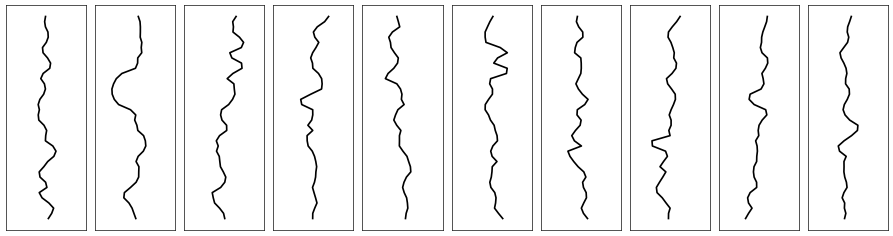

In [13]:
ix = ix + 10 # advance the test set pointer
xs = data['x_test'][ix:ix+10]
t = data['t']
_ = plot_signals(xs, t, args=args, ratio=2.7, zoom=6)

In [14]:
# guess = [0,0,0,0,0,0,0,0,0,0]
guess = [2,6,3,9,4,3,1,9,5,2]

true = data['y_test'][ix:ix+10]
print('guess:', np.asarray(guess))
print('truth:', true)
print(np.sum(np.asarray(guess)==true), 'correct')
datas += list(xs) ; guesses += list(guess) ; trues += list(true)
print('len(guesses) = {}/100'.format(len(guesses)))
# path = './static/human_{}.pkl'.format(quiz_tag)
# to_pickle([datas, guesses, trues], path)

guess: [2 6 3 9 4 3 1 9 5 2]
truth: [2 6 3 9 4 3 1 9 5 2]
10 correct
len(guesses) = 10/100


### Quiz: step 4
Visualize human performance stats

In [15]:
tags = ['q1', 'q2', 'q3', 'q4', 'q5']

datas, guesses, trues = [], [], []
accs = []
for tag in tags:
    [d, g, t] = from_pickle('mnist1d/static/human_{}.pkl'.format(tag))
    acc = 100.*np.sum(np.asarray(g)==np.asarray(t))/len(g)
    print(tag, acc)
    accs.append(acc)
    datas += d ; guesses += g ; trues += t
accs, datas, guesses, trues = [np.array(v) for v in [accs, datas, guesses, trues]]
    
print("Bootstrap accuracy estimate:", 100.*np.sum(guesses==trues)/len(guesses),\
     '+/- {:.2f}'.format(np.std(accs)/np.sqrt(len(accs))))

FileNotFoundError: [Errno 2] No such file or directory: 'mnist1d/static/human_q1.pkl'

In [16]:
fig = plt.figure(figsize=(3.5, 2.5), dpi=150)
err_ixs = np.where(guesses!=trues)
err_classes = trues[err_ixs]

labels = [i for i in range(10)]
err_rate = [100. * np.sum(err_classes == i)/np.sum(trues==i) for i in labels]
x_pos = [i for i, _ in enumerate(labels)]

plt.bar(x_pos, err_rate, color='green')
plt.xlabel("Label")
plt.ylabel("% misclassified")
plt.title("Human mistakes by class label")

plt.xticks(x_pos, labels)

plt.tight_layout() ; plt.show()
# fig.savefig(PROJECT_DIR + 'static/classwise_human_errors.png')

/var/folders/ly/jkydg4dj2vs93b_ds7yp5t7r0000gn/T/ipykernel_28831/3339750553.py:2: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  err_ixs = np.where(guesses!=trues)


TypeError: list indices must be integers or slices, not tuple

<Figure size 525x375 with 0 Axes>

## Run ML model benchmarks
We'll use some boilerplate models and training code that is included in the ``mnist1d`` repo.

In [17]:
from mnist1d.models import ConvBase, MLPBase, LinearBase, GRUBase
from mnist1d.train import get_model_args, train_model

In [18]:
# Note: if you run on a GPU, the walltimes will be _much_ lower
args = get_model_args()
args.total_steps = 6000
args.device = DEVICE

set_seed(args.seed)
model = ConvBase(output_size=args.output_size)
results_cnn = train_model(data, model, args)
print()

set_seed(args.seed)
model = GRUBase(input_size=1, output_size=args.output_size)
results_gru = train_model(data, model, args)
print()

set_seed(args.seed)
model = MLPBase(args.input_size, args.output_size)
results_mlp = train_model(data, model, args)
print()

set_seed(args.seed)
model = LinearBase(args.input_size, args.output_size)
results_lin = train_model(data, model, args)
print()

Initialized ConvBase model with 5210 parameters


KeyboardInterrupt: 

In [ ]:
# Note: if you run on a GPU, the walltimes will be _much_ lower
args = get_model_args()
args.total_steps = 6000
args.device = DEVICE

set_seed(args.seed)
model = ConvBase(output_size=args.output_size)
results_cnn_shuff = train_model(data_shuff, model, args)
print()

set_seed(args.seed)
model = GRUBase(input_size=1, output_size=args.output_size)
results_gru_shuff = train_model(data_shuff, model, args)
print()

set_seed(args.seed)
model = MLPBase(args.input_size, args.output_size)
results_mlp_shuff = train_model(data_shuff, model, args)
print()

set_seed(args.seed)
model = LinearBase(args.input_size, args.output_size)
results_lin_shuff = train_model(data_shuff, model, args)

### Use early-stopping to select a good CNN model
We'll run a per-class error rate analysis on it, like we did for human labels.

In [ ]:
args = mnist1d.get_model_args()
args.total_steps = 3000  # approx early stopping based on CNN training in earlier cells

set_seed(args.seed)
model = ConvBase(output_size=args.output_size)
_ = train_model(data, model, args)

In [ ]:
preds = model(torch.Tensor(data['x_test'])).cpu().detach().numpy()
guesses = preds.argmax(-1)[:500]
trues = data['y_test'][:500]
print("Accuracy: ", 100.*np.sum(guesses==trues)/len(guesses))

In [ ]:
err_ixs = np.where(guesses!=trues)
err_classes = trues[err_ixs]

labels = [i for i in range(10)]
err_rate = [100. * np.sum(err_classes == i)/np.sum(trues==i) for i in labels]
x_pos = [i for i, _ in enumerate(labels)]

fig = plt.figure(figsize=(3.5, 2.5), dpi=150)
plt.bar(x_pos, err_rate, color='green')
plt.xlabel("Label")
plt.ylabel("% misclassified")
plt.title("CNN mistakes by class label")

plt.xticks(x_pos, labels)

plt.tight_layout() ; plt.show()
# fig.savefig(PROJECT_DIR + 'static/classwise_cnn_errors.png')

### Takeaways
An experienced human can classify these examples at almost 96% accuracy. The CNN can do so at 93% accuracy. Both the human and the CNN struggle primarily with classifying 2s and 7s, and to a lesser degree 4s. The human had a harder time classifying 9s whereas the CNN had a harder time classifying 1s. Both had zero errors classifying 3s and 6s.

Classification errors were fairly evenly balanced across classes, which is a good sign. If only one or two classes were responsible for most of the mistakes, that would have been a sign that those classes were too difficult compared to the others.

It's interesting that a human can outperform a CNN on this simple task. Part of the issue is that the CNN is only given 4000 training examples -- with more examples it might be able to match or exceed the human baseline. Even though the data is low dimensional, the classification objective is quite difficult and spatial/relational priors matter _a lot_. It may be that the architecture of the CNN prevents it from learning all of the tricks that humans are capable of using (eg, using relational reasoning about two signals to determine how they work together to form the digit signal).

It's worth noting that CNNs outperform human experts on most large-scale image classification tasks like ImageNet and CIFAR-100. But here is a tiny benchmark where humans are still competitive -- this is a nice quality, as it suggests that the key to performing well on the dataset does not rest on [shortcut learning](https://arxiv.org/abs/2004.07780) such as memorizing specific numbers or patterns to machine precision. A high-performing ML model, we can hope, would have to solve the problem using strategies that would be intuitive to a human.

## Plot all benchmarks
The goal here is to give a global overview of all the benchmarks we just ran. The large gap in performance between logistic regression and the MLP suggests that nonlinear features are important. The large gap between the MLP and the CNN suggests that spatial inductive biases are important. The strong human performance shows that one can attain good performance on this dataset without using shortcut learning or memorization (if that were the case, then we'd expect the CNN to do better than the human).

In [ ]:
fig = plt.figure(figsize=(4.1, 3), dpi=150)
args.total_steps = 6000

plt.subplot(1,1,1)
t = range(0, args.total_steps+1, args.eval_every)
plt.plot(t, results_lin['test_acc'], 'r-', label='logistic')
plt.plot(t, results_lin_shuff['test_acc'], 'r--', label='shuffle')

plt.plot(t, results_mlp['test_acc'], 'g-', label='mlp')
plt.plot(t, results_mlp_shuff['test_acc'], 'g--', label='shuffle')

plt.plot(t, results_cnn['test_acc'], 'b-', label='cnn')
plt.plot(t, results_cnn_shuff['test_acc'], 'b--', label='shuffle')

plt.plot(t, results_gru['test_acc'], 'c-', label='gru')
plt.plot(t, results_gru_shuff['test_acc'], 'c--', label='shuffle')

plt.plot(t, [95.8]*len(t), 'k-', label='human')

plt.title('Test accuracy') ; plt.xlabel("Train step")
plt.legend(fontsize=6, ncol=5, loc='lower right')
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9)
plt.ylim(0,105)
plt.tight_layout() ; plt.show()
# fig.savefig(PROJECT_DIR + 'static/benchmarks.png')

## Conclusions
We believe this dataset is ideal for performing small-scale, "science of deep learning" experiments.

Try it out, do something interesting, and share it with us via a Colab. We would like to feature your work in our README.